In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import talos

np.random.seed(123)

In [4]:
test_folder = 'data/chest_xray/chest_xray/test'
train_folder = 'data/chest_xray/chest_xray/train'
val_folder = 'data/chest_xray/chest_xray/val'

In [5]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(80, 80),
        batch_size = 624,
        class_mode='binary') 

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(80, 80),
        batch_size= 5216,
        class_mode='binary')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(80, 80),
        batch_size = 16,
        class_mode='binary')



Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(5216, 80, 80, 3)
(624, 80, 80, 3)
(16, 80, 80, 3)
(5216,)
(624,)
(16,)


In [8]:
train_generator.class_indices 

{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
test_generator.class_indices 

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
val_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

In [12]:
print(train_img.shape)
print(test_img.shape)

(5216, 19200)
(624, 19200)


In [13]:
train_y = np.reshape(train_labels[:], (5216,1))
test_y = np.reshape(test_labels[:], (624,1))
print(test_y.shape)
print(train_y.shape)

(624, 1)
(5216, 1)


Label: 0.0


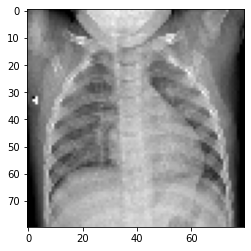

In [14]:
sample_image = train_images[0]
sample_label = train_labels[0]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

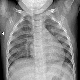

In [15]:
array_to_img(train_images[0])

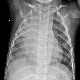

In [16]:
array_to_img(train_images[10])

In [17]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(5216, 80, 80, 3)
(624, 80, 80, 3)
(16, 80, 80, 3)
(5216,)
(624,)
(16,)


In [26]:
def cnn_model(train_img, train_y, test_img, test_y, params):

    model = Sequential()

    # hidden layers
    model.add(Conv2D(params['nodes_cnn'], (3, 3),
                             activation= params['activation_cnn'],
                         input_shape=(80, 80, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(params['dropout']))

    model.add(layers.Dense(params['nodes_dense'],
                           activation= params['activation_dense'], input_dim= 19200,))
    model.add(layers.Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy',
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    
    out = model.fit(train_img, train_y, 
                        validation_data= (test_img, test_y),
                        batch_size=50,
                        epochs=10,
                        verbose=0)

    return out, model

In [27]:
print(train_img.shape)
print(test_img.shape)
print(train_y.shape)
print(test_y.shape)

(5216, 19200)
(624, 19200)
(5216, 1)
(624, 1)


In [28]:
params = {'dropout': [0.1, 0.25, 0.5],
          'nodes_cnn':[32, 64,128],
          'nodes_dense': [12, 20, 100],
          'optimizer': ['adam', 'sgd'], 
          'activation_cnn': ['relu', 'softmax'], 
          'activation_dense': ['relu', 'elu']}

In [29]:
results = talos.Scan(train_images, train_labels, 
                     params=params,
                     model= cnn_model,
                     experiment_name='grid')


  2%|▏         | 5/216 [08:03<5:46:35, 98.56s/it] 

KeyboardInterrupt: 

In [ ]:
results.best_model('accuracy')

In [ ]:
pd.read_csv('grid/090721121658.csv').sort_values('val_accuracy', ascending=False)

,round_epochs,loss,accuracy,val_loss,val_accuracy,activation_cnn,activation_dense,dropout,nodes_cnn,nodes_dense,optimizer
34,10,0.007022,0.999726,0.097082,0.971246,relu,relu,0.25,128,100,adam
52,10,0.025166,0.991509,0.082048,0.971246,relu,relu,0.50,128,100,adam
4,10,0.011964,0.997535,0.089077,0.970607,relu,relu,0.10,32,100,adam
16,10,0.003720,1.000000,0.105102,0.968690,relu,relu,0.10,128,100,adam
100,10,0.030519,0.990961,0.094383,0.968051,relu,elu,0.50,64,100,adam
...,...,...,...,...,...,...,...,...,...,...,...
89,10,0.268755,0.937825,1.958170,0.387220,relu,elu,0.25,128,100,sgd
73,10,0.147629,0.941660,5.079805,0.251757,relu,elu,0.25,32,12,sgd
41,10,0.189200,0.933169,3.891972,0.249840,relu,relu,0.50,32,100,sgd
5,10,0.181600,0.927143,7.560186,0.248562,relu,relu,0.10,32,100,sgd
